# Variable and model preparation

In [ ]:
pre, code {
  max-height: 500px;
  overflow-y: auto;
  white-space: pre !important; 
  overflow-x: auto
}

In [ ]:
# to detect and warn about conflicts
library(conflicted)

conflict_prefer("filter", "dplyr")

[conflicted] Will prefer dplyr::filter over any other package.

[conflicted] Will prefer dplyr::select over any other package.

[conflicted] Will prefer lmerTest::lmer over any other package.

In [ ]:
# to read in data
library(readr)

path_ready <- "_data/data_ready"

# for data wrangling and cleaning
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1

Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

In [ ]:
d <- read_csv(here::here(path_ready, "miced_1.csv"), show_col_types = FALSE)

### Variable preparation

#### Verbal

Create ordered bins for verbal consent cues

In [ ]:
d <- d %>%
  mutate(
    verb_bins = cut(
      verb,
      breaks = c(-Inf, 0, 3, 6, 9, Inf),
      labels = c("Not at all", "A little", 
                 "Somewhat", "Quite a bit", "Very much"),
      right = TRUE,
      include.lowest = TRUE),
    verb_bins = ordered(verb_bins,
                        levels = c("Not at all", "A little", 
                                   "Somewhat", "Quite a bit", "Very much")))

# Verify
is.ordered(d$verb_bins)

[1] TRUE


 Not at all    A little    Somewhat Quite a bit   Very much 
        121          61          59          92         168 

#### Nonverbal

Composite

In [ ]:
d <- d %>%
  rowwise() %>%  # calculate mean score
  mutate(nvrb = mean(c(enon, inon)))

psych::describe(d$nvrb)

   vars   n mean   sd median trimmed  mad min max range  skew kurtosis   se
X1    1 501 6.93 3.28      8     7.4 2.97   0  10    10 -0.86    -0.49 0.15

Create ordered bins for nonverbal consent cues

In [ ]:
d <- d %>%
  mutate(
    nonvb_bins = cut(
      nvrb,
      breaks = c(-Inf, 0, 3, 6, 9, Inf),
      labels = c("Not at all", "A little", 
                 "Somewhat", "Quite a bit", "Very much"),
      right = TRUE,
      include.lowest = TRUE
    ),
    nonvb_bins = ordered(nonvb_bins,
                         levels = c("Not at all", "A little", 
                                    "Somewhat", "Quite a bit", "Very much")))
# Verify
is.ordered(d$nonvb_bins)

[1] TRUE


 Not at all    A little    Somewhat Quite a bit   Very much 
         46          33          99         147         176 

#### Familiarity

Friend and acquaintance categories showed sparse coverage across several ordinal outcome bins.

In [ ]:
d <- d %>%
  mutate(
    fam_lev = case_when(
      fm_r == 1 ~ "Stranger",
      fm_r %in% c(2, 3) ~ "Friend/Acq",
      fm_r == 4 ~ "Romantic"),
    fam_lev = factor(fam_lev,
                     levels = c("Stranger", "Friend/Acq", "Romantic")))

levels(d$fam_lev)     # Stranger is referent

[1] "Stranger"   "Friend/Acq" "Romantic"  

[1] FALSE


  Stranger Friend/Acq   Romantic 
        40        123        338 

Two-level partner familiarity variable. Are encounters embedded in a romantic relational context higher in nonverbal cue use overall?

In [ ]:
d <- d %>%
  mutate(
    fam_rank = case_when(
      fm_r %in% c(1, 2, 3) ~ "Less",  # Friend, Stranger, or Acquaintance
      fm_r %in% c(4) ~ "More"), # Romantic 
    fam_rank = factor(fam_rank,
                     levels = c("Less", "More")))

levels(d$fam_rank)     # Stranger is referent

[1] "Less" "More"

[1] FALSE


Less More 
 163  338 

#### Intoxication “disparity”

In [ ]:
# Continuous parity = absolute difference between self and partner intoxication
d$parity_con <- abs(d$intox - d$p_tox)

psych::describe(d$parity_con)

   vars   n mean    sd median trimmed mad min max range skew kurtosis  se
X1    1 501 5.74 11.19      0    2.95   0   0  72    72 2.66     8.02 0.5


         Equal    Self-Higher Partner-Higher 
           283            116            102 

#### AUDIT

*Calculate total score post-imputation (4 obs = NA for aud2).*

In [ ]:
# AUDIT summed score 
d <- d %>% 
rowwise() %>% dplyr::mutate(auds = sum(aud1,aud2,aud3,aud4,aud5,
                                       aud6,aud7,aud8,aud9,aud10))

# AUDIT descriptives
psych::describe(d$auds)

   vars   n mean   sd median trimmed  mad min max range skew kurtosis   se
X1    1 501 9.73 5.79      9    9.06 5.93   1  34    33 1.15     1.62 0.26


Reliability analysis   
Call: psych::alpha(x = d[, audit_vector], check.keys = T)

  raw_alpha std.alpha G6(smc) average_r S/N   ase mean   sd median_r
      0.81      0.82    0.86      0.32 4.6 0.012 0.97 0.58     0.27

    95% confidence boundaries 
         lower alpha upper
Feldt     0.79  0.81  0.84
Duhachek  0.79  0.81  0.84

 Reliability if an item is dropped:
      raw_alpha std.alpha G6(smc) average_r S/N alpha se var.r med.r
aud1       0.80      0.82    0.85      0.33 4.4    0.013 0.033  0.28
aud2       0.79      0.81    0.83      0.31 4.1    0.014 0.030  0.26
aud3       0.78      0.79    0.81      0.30 3.8    0.014 0.028  0.26
aud4       0.78      0.79    0.83      0.29 3.7    0.014 0.033  0.24
aud5       0.79      0.80    0.83      0.30 3.9    0.014 0.033  0.26
aud6       0.82      0.84    0.87      0.36 5.1    0.012 0.029  0.37
aud7       0.79      0.80    0.84      0.31 4.1    0.013 0.035  0.27
aud8       0.77      0.79    0.82      0.29 3.7    0.015 0.029  0.24
aud9    

### Set factor levels

In [ ]:
d %>% select(prec, bpa, s_act, gend_di) %>% map(tabyl)

$prec
 .x[[i]]   n   percent
       0  94 0.1876248
       1 407 0.8123752

$bpa
 .x[[i]]   n   percent
       0 319 0.6367265
       1 182 0.3632735

$s_act
     .x[[i]]   n   percent
     Contact 198 0.3952096
 Penetration 303 0.6047904

$gend_di
 .x[[i]]   n   percent
       0 310 0.6187625
       1 191 0.3812375

### Decompose

#### L1 Numeric

In [ ]:
d <- decompose_num(
  df   = d,
  id   = "nid",
  vars = c("intox", "parity_con", "drink", "p_tox"))

Check decomposition (repeated for all four vars)

In [ ]:
d %>%
  group_by(nid) %>%
  summarise(m_wp = mean(parity_con_wp), .groups="drop") %>%
  summarise(max_abs = max(abs(m_wp)),
            overall = mean(m_wp))

# A tibble: 1 × 2
   max_abs  overall
     <dbl>    <dbl>
1 2.37e-15 7.41e-18

# A tibble: 1 × 1
  max_abs_err
        <dbl>
1           0

#### L1 factors

In [ ]:
d <- decompose_factor_any(
  df       = d,
  id       = "nid",
  var      = "prec",
  baseline = "No_history",
  prefix   = "prec")

In [ ]:
d <- decompose_factor_any(
  df       = d,
  id       = "nid",
  var      = "bpa",
  baseline = "False",
  prefix   = "bpa"
)

In [ ]:
d <- decompose_factor_any(
  df       = d,
  id       = "nid",
  var      = "s_act",
  baseline = "Contact",
  prefix   = "act"
)

In [ ]:
d <- decompose_factor_any(
  df       = d,
  id       = "nid",
  var      = "fam_lev",
  baseline = "Stranger",
  prefix   = "fam3"
)

In [ ]:
d <- decompose_factor_any(
  df       = d,
  id       = "nid",
  var      = "fam_rank",
  baseline = "Less",
  prefix   = "fam2"
)

In [ ]:
d <- decompose_factor_any(
  df       = d,
  id       = "nid",
  var      = "parity_cat",
  baseline = "Equal",
  prefix   = "dis"
)

levels(d$parity_cat)

[1] "Equal"          "Self-Higher"    "Partner-Higher"

### Center

In [ ]:
pm_cols <- names(d)[grepl("_pm$", names(d))]
d <- grand_mean_center(d, cols = pm_cols)

In [ ]:
names(d)[grepl("^prec_", names(d))]
names(d)[grepl("^bpa_",  names(d))]
names(d)[grepl("^act_", names(d))]
names(d)[grepl("^fam3_", names(d))]
names(d)[grepl("^fam2_", names(d))]
names(d)[grepl("^dis_", names(d))]

#### + Standardize

In [ ]:
# person-level predictors (baseline)
d <- grand_mean_center(
  d,
  cols = c("bidr", "auds", "irma", "ppat", "asco"),
  scale = TRUE
)

Continuous person-level predictors were grand-mean centered and, where appropriate, standardized (z-scored) to facilitate interpretability and comparability across constructs measured on different scales. Between-person components of time-varying predictors were grand-mean centered. Within-person deviation terms and categorical predictors were not standardized.

### Transform for LMMs

In [ ]:
rec_outcomes <- recipe(~ ., data = d) %>%
  step_YeoJohnson(verb, nvrb)

prep_rec <- prep(rec_outcomes, training = d)

prep_rec

── Recipe ──────────────────────────────────────────────────────────────────────

── Inputs 

Number of variables by role

predictor: 85

── Training information 

Training data contained 501 data points and no incomplete rows.

── Operations 

• Yeo-Johnson transformation on: verb nvrb | Trained

# A tibble: 2 × 3
  terms value id              
  <chr> <dbl> <chr>           
1 verb  0.719 YeoJohnson_8tSPs
2 nvrb  1.48  YeoJohnson_8tSPs

   vars   n mean   sd median trimmed  mad min  max range  skew kurtosis   se
X1    1 501 3.78 2.62   4.82    3.92 2.37   0 6.41  6.41 -0.41     -1.5 0.12

   vars   n  mean   sd median trimmed  mad min   max range  skew kurtosis   se
X1    1 501 14.82 7.94  16.82   15.65 8.98   0 22.88 22.88 -0.56    -1.06 0.35

In [ ]:
d_check <- d %>%
  transmute(
    verb_orig = verb,
    nvrb_orig = nvrb
  ) %>%
  bind_cols(
    d_lmm %>% transmute(verb_yj, nvrb_yj)
  )

with(d_check, cor(verb_orig, verb_yj))

[1] 0.99768

[1] 0.9929539

[1] 3.587261

[1] 12.88238

# A tibble: 10 × 4
   verb_orig verb_yj nvrb_orig nvrb_yj
       <dbl>   <dbl>     <dbl>   <dbl>
 1         8    5.36      10      22.9
 2        10    6.41       0       0  
 3        10    6.41      10      22.9
 4         6    4.25       9      19.8
 5         0    0          8      16.8
 6         8    5.36       8      16.8
 7        10    6.41      10      22.9
 8        10    6.41      10      22.9
 9         0    0          5.5    10.1
10        10    6.41      10      22.9

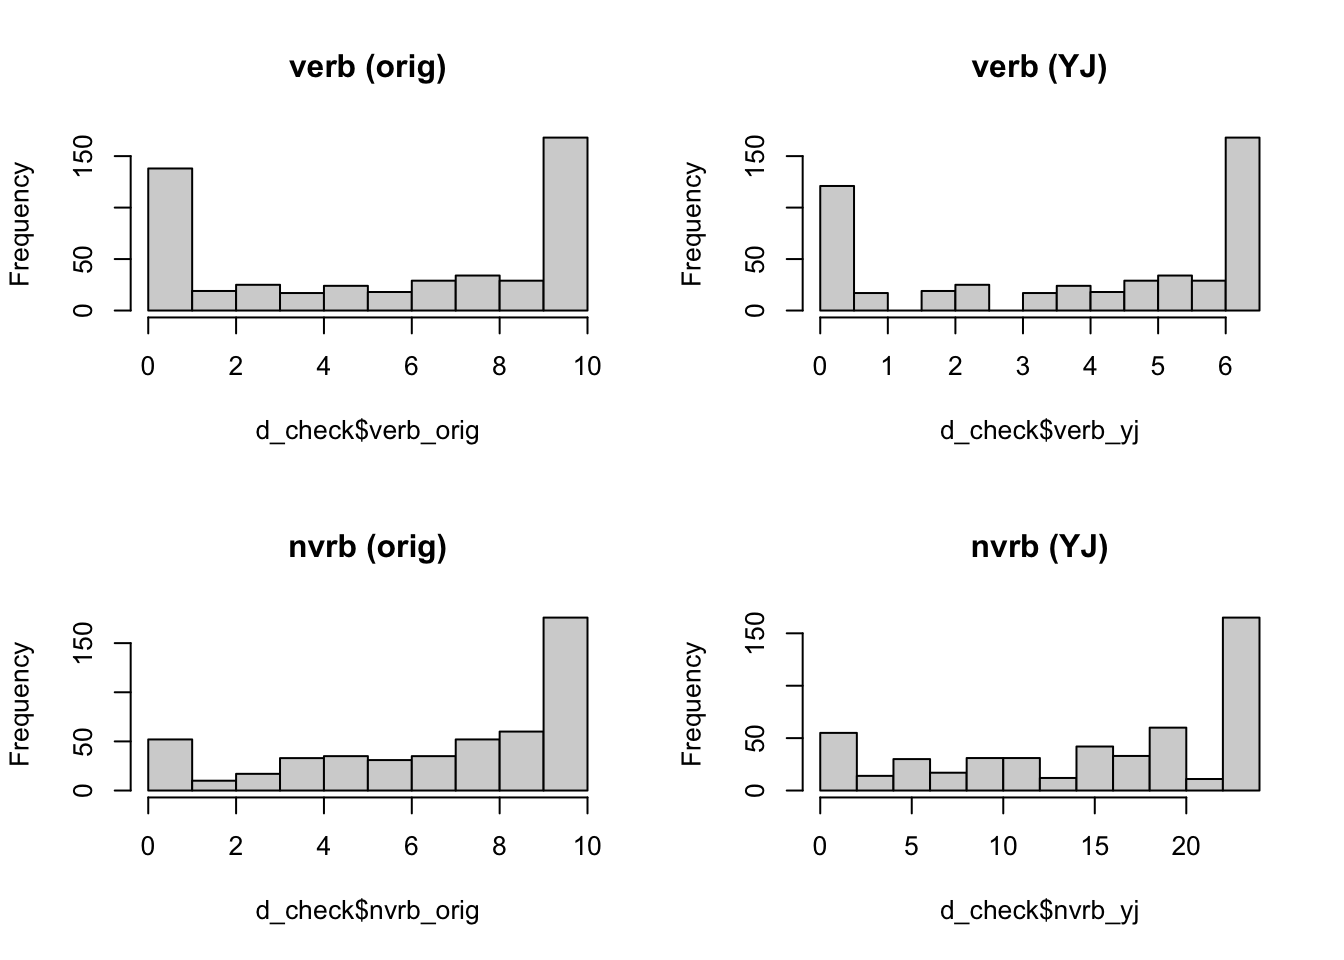

In [ ]:
par(mfrow = c(2,2))
hist(d_check$verb_orig, main = "verb (orig)")
hist(d_check$verb_yj,   main = "verb (YJ)")
hist(d_check$nvrb_orig, main = "nvrb (orig)")
hist(d_check$nvrb_yj,   main = "nvrb (YJ)")

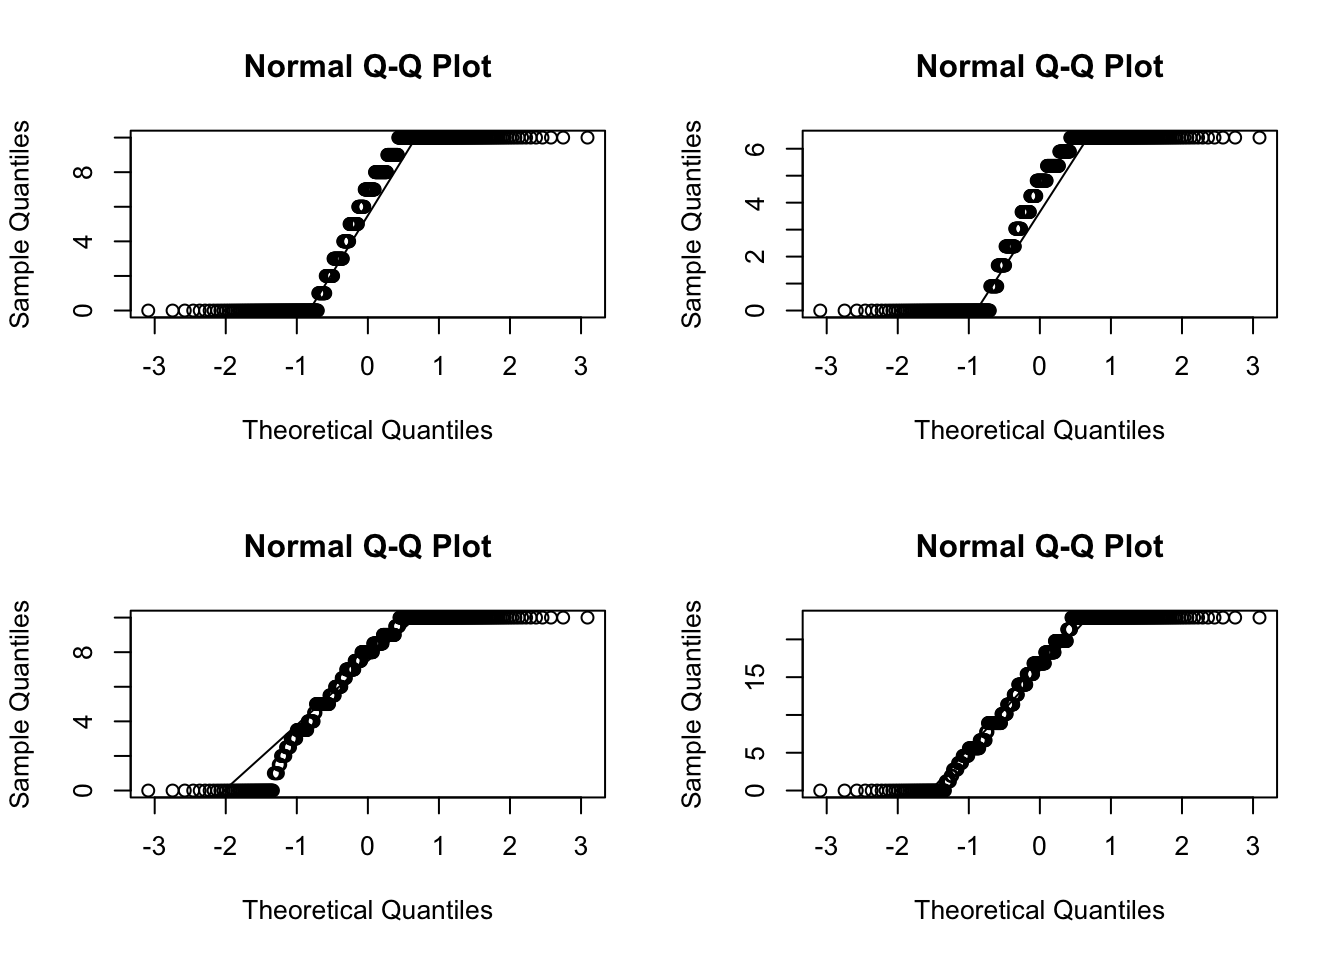

In [ ]:
par(mfrow = c(2,2))
qqnorm(d_check$verb_orig); qqline(d_check$verb_orig)
qqnorm(d_check$verb_yj);   qqline(d_check$verb_yj)
qqnorm(d_check$nvrb_orig); qqline(d_check$nvrb_orig)
qqnorm(d_check$nvrb_yj);   qqline(d_check$nvrb_yj)

In [ ]:
c(
  verb_skew_orig = skewness(d_check$verb_orig),
  verb_skew_yj   = skewness(d_check$verb_yj),
  nvrb_skew_orig = skewness(d_check$nvrb_orig),
  nvrb_skew_yj   = skewness(d_check$nvrb_yj)
)

verb_skew_orig   verb_skew_yj nvrb_skew_orig   nvrb_skew_yj 
    -0.2909172     -0.4071935     -0.8580813     -0.5649141 

### ICCs

#### LMEMs

**Verbal**

In [ ]:
v_null <- lmer(verb_yj ~ 1 + (1 | nid), data = d_lmm, REML = TRUE)
icc_verb <- icc_lmm(v_null, group = "nid")
within_verb <- 1 - icc_verb

icc_verb

[1] 0.52381

[1] 0.47619

**Nonverbal**

In [ ]:
n_null <- lmer(nvrb_yj ~ 1 + (1 | nid), data = d_lmm, REML = TRUE)
icc_nvrb <- icc_lmm(n_null, group = "nid")
within_nvrb <- 1 - icc_nvrb

icc_nvrb

[1] 0.6773149

[1] 0.3226851

In [ ]:
icc_table <- bind_rows(
  icc_lmm_ci(v_null, group = "nid", R = 2000) %>% mutate(Outcome = "Verbal cues"),
  icc_lmm_ci(n_null, group = "nid", R = 2000) %>% mutate(Outcome = "Nonverbal cues")
) %>%
  mutate(
    `1 - ICC` = 1 - ICC,
    ICC = strip0(sprintf("%.3f", ICC)),
    `95% CI` = strip0(sprintf("[%.3f, %.3f]", ICC_low, ICC_high)),
    `1 - ICC` = strip0(sprintf("%.3f", `1 - ICC`))
  ) %>%
  select(Outcome, ICC, `95% CI`, `1 - ICC`)

saveRDS(icc_table, here::here("objects/icc_table.rds"))

#### Cell sizes

For some event-level predictors, within-person variability was limited; accordingly, within-person effects are estimated from the subset of participants who experienced variation in these characteristics.

In [ ]:
d_lmm %>%
  group_by(nid) %>%
  summarise(act_varies = n_distinct(s_act, na.rm = TRUE), .groups="drop") %>%
  count(act_varies)

# A tibble: 2 × 2
  act_varies     n
       <int> <int>
1          1   104
2          2    48

# A tibble: 1 × 1
  prop_vary
      <dbl>
1     0.309

# A tibble: 1 × 1
  prop_vary
      <dbl>
1     0.243

# A tibble: 2 × 2
  prec_varies     n
        <int> <int>
1           1   115
2           2    37

# A tibble: 3 × 2
  fam_varies     n
       <int> <int>
1          1   120
2          2    30
3          3     2

# A tibble: 3 × 2
  par_varies     n
       <int> <int>
1          1    87
2          2    45
3          3    20

# A tibble: 3 × 2
  par_varies     n
       <int> <int>
1          1    87
2          2    45
3          3    20

### Time effects

Evaluate study `day` for inclusion in **verbal** models as fixed design covariate and assess support for random slope

In [ ]:
d_lmm <- d_lmm %>%   # center
  mutate(day_c = day - mean(day))

v_null <- lmer(verb_yj ~ 1 + 
                 (1 | nid), data = d_lmm, REML = FALSE)

v_m0 <- lmer(verb_yj ~ day_c +
               (1 | nid), data = d_lmm, REML = FALSE) # compare to unconditional LMEM

anova(v_null, v_m0) # support for fixed design covariate? No

Data: d_lmm
Models:
v_null: verb_yj ~ 1 + (1 | nid)
v_m0: verb_yj ~ day_c + (1 | nid)
       npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)  
v_null    3 2223.2 2235.8 -1108.6    2217.2                       
v_m0      4 2222.1 2238.9 -1107.0    2214.1 3.1021  1    0.07819 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

refitting model(s) with ML (instead of REML)

Data: d_lmm
Models:
v_m0: verb_yj ~ day_c + (1 | nid)
v_m1: verb_yj ~ day_c + (1 + day_c | nid)
     npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)    
v_m0    4 2222.1 2238.9 -1107.0    2214.1                         
v_m1    6 2211.7 2237.0 -1099.8    2199.7 14.367  2   0.000759 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Groups   Name        Std.Dev. Corr  
 nid      (Intercept) 1.880957       
          day_c       0.080041 -0.015
 Residual             1.684267       

       grp        var1  var2         vcov       sdcor
1      nid (Intercept)  <NA>  3.538000421  1.88095732
2      nid       day_c  <NA>  0.006406525  0.08004077
3      nid (Intercept) day_c -0.002267123 -0.01505861
4 Residual        <NA>  <NA>  2.836755764  1.68426713

[1] FALSE

Likelihood ratio tests of cumulative link models:
 
            formula:                      link: threshold:
v_null_clmm verb_bins ~ 1 + (1 | nid)     logit flexible  
v_m0_clmm   verb_bins ~ day_c + (1 | nid) logit flexible  

            no.par    AIC  logLik LR.stat df Pr(>Chisq)
v_null_clmm      5 1385.5 -687.76                      
v_m0_clmm        6 1385.1 -686.56  2.3913  1      0.122

Likelihood ratio tests of cumulative link models:
 
          formula:                              link: threshold:
v_m0_clmm verb_bins ~ day_c + (1 | nid)         logit flexible  
v_m1_clmm verb_bins ~ day_c + (1 + day_c | nid) logit flexible  

          no.par    AIC  logLik LR.stat df Pr(>Chisq)   
v_m0_clmm      6 1385.1 -686.56                         
v_m1_clmm      8 1378.7 -681.34   10.45  2   0.005381 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: verb_bins ~ day_c + (1 + day_c | nid)
data:    d_lmm

 link  threshold nobs logLik  AIC     niter     max.grad cond.H 
 logit flexible  501  -681.34 1378.67 835(4607) 7.47e-04 7.9e+02

Random effects:
 Groups Name        Variance Std.Dev. Corr  
 nid    (Intercept) 5.428959 2.33001        
        day_c       0.008092 0.08996  0.119 
Number of groups:  nid 152 

Coefficients:
      Estimate Std. Error z value Pr(>|z|)
day_c  0.01808    0.01806   1.001    0.317

Threshold coefficients:
                      Estimate Std. Error z value
Not at all|A little    -2.2563     0.2863  -7.882
A little|Somewhat      -1.1779     0.2605  -4.521
Somewhat|Quite a bit   -0.2631     0.2494  -1.055
Quite a bit|Very much   1.1322     0.2548   4.443

Evaluate study `day` for inclusion in **nonverbal** models as fixed design covariate and assess support for random slope

In [ ]:
n_null <- lmer(nvrb_yj ~ 1 + 
                 (1 | nid), data = d_lmm, REML = FALSE)

n_m0 <- lmer(nvrb_yj ~ day_c + # compare to unconditional LMEM
               (1 | nid), data = d_lmm, REML = FALSE)

anova(n_null, n_m0) # support for fixed covariate? No

Data: d_lmm
Models:
n_null: nvrb_yj ~ 1 + (1 | nid)
n_m0: nvrb_yj ~ day_c + (1 | nid)
       npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
n_null    3 3210.8 3223.5 -1602.4    3204.8                     
n_m0      4 3212.8 3229.6 -1602.4    3204.8 0.0675  1      0.795

Warning in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
Model failed to converge with max|grad| = 0.00481605 (tol = 0.002, component 1)

Likelihood ratio tests of cumulative link models:
 
            formula:                       link: threshold:
n_null_clmm nonvb_bins ~ 1 + (1 | nid)     logit flexible  
n_m0_clmm   nonvb_bins ~ day_c + (1 | nid) logit flexible  

            no.par    AIC  logLik LR.stat df Pr(>Chisq)
n_null_clmm      5 1209.7 -599.84                      
n_m0_clmm        6 1211.7 -599.84   2e-04  1     0.9889

Likelihood ratio tests of cumulative link models:
 
          formula:                               link: threshold:
n_m0_clmm nonvb_bins ~ day_c + (1 | nid)         logit flexible  
n_m1_clmm nonvb_bins ~ day_c + (1 + day_c | nid) logit flexible  

          no.par    AIC  logLik LR.stat df Pr(>Chisq)
n_m0_clmm      6 1211.7 -599.84                      
n_m1_clmm      8 1212.9 -598.43  2.8282  2     0.2431

### Random slopes

#### Verbal

**Sexual act** — People differ meaningfully in how much their verbal consent cue use changes when encounters involve penetration versus contact. **Include** random slope.

In [ ]:
test_random_slope(
  outcome = "verb_yj",
  wp = "act_penetration_wp",
  pm_c = "act_penetration_pm_c",
  data = d_lmm)

$lrt
Data: data
Models:
m0: f0
m1: f1
   npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)  
m0    5 2193.2 2214.3 -1091.6    2183.2                       
m1    7 2190.9 2220.4 -1088.5    2176.9 6.2939  2    0.04298 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

$random_effects
 Groups   Name               Std.Dev. Corr 
 nid      (Intercept)        1.8502        
          act_penetration_wp 1.4378   0.063
 Residual                    1.6726        

$singular
[1] FALSE

$keep_random_slope
[1] TRUE

Verbal consent cue use was significantly higher during penetrative sexual encounters compared to encounters that did not progress beyond kissing or touching. This effect was observed within individuals, indicating that when a given participant engaged in penetrative sexual activity, they reported greater use of verbal consent cues than during their own contact-only encounters. Although the magnitude of this effect varied across individuals, the average within-person association was positive.

In [ ]:
m_act <- lmer(
  verb_yj ~ act_penetration_wp + act_penetration_pm_c +
    (1 + act_penetration_wp + day_c | nid),
  data = d_lmm,
  REML = TRUE)

summary(m_act)

act_raw <- lmer(
  verb ~ act_penetration_wp + act_penetration_pm_c +
    (1 + act_penetration_wp + day_c | nid),
  data = d,
  REML = TRUE)

Visual inspection of standardized residual Q–Q plots indicated modest improvements in residual normality following Yeo–Johnson transformation, particularly in the upper tail; transformed outcomes were therefore retained for primary LMMs.

In [ ]:
par(mfrow = c(1, 2))

qqnorm(scale(resid(act_raw)),
       main = "Raw outcome (standardized residuals)")
qqline(scale(resid(act_raw)))

qqnorm(scale(resid(m_act)),
       main = "YJ outcome (standardized residuals)")
qqline(scale(resid(m_act)))

par(mfrow = c(1, 1))

**Include** random slope for verbal if using 2-level **familiarity**.

In [ ]:
test_random_slope(
  outcome = "verb_yj",
  wp = "fam2_more_wp",
  pm_c = "fam2_more_pm_c",
  data = d_lmm)

$lrt
Data: data
Models:
m0: f0
m1: f1
   npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)  
m0    5 2220.2 2241.2 -1105.1    2210.2                       
m1    7 2215.6 2245.1 -1100.8    2201.6 8.6063  2    0.01353 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

$random_effects
 Groups   Name         Std.Dev. Corr 
 nid      (Intercept)  1.8931        
          fam2_more_wp 1.8173   0.202
 Residual              1.7454        

$singular
[1] FALSE

$keep_random_slope
[1] TRUE

Exclude random slope for precedent predicting verbal.

In [ ]:
test_random_slope(
  outcome = "verb_yj",
  wp = "prec_history_wp",
  pm_c = "prec_history_pm_c",
  data = d_lmm
)

$lrt
Data: data
Models:
m0: f0
m1: f1
   npar    AIC    BIC  logLik -2*log(L) Chisq Df Pr(>Chisq)
m0    5 2222.5 2243.6 -1106.2    2212.5                    
m1    7 2225.9 2255.5 -1106.0    2211.9 0.546  2     0.7611

$random_effects
 Groups   Name            Std.Dev. Corr  
 nid      (Intercept)     1.86871        
          prec_history_wp 0.84398  -0.078
 Residual                 1.78837        

$singular
[1] FALSE

$keep_random_slope
[1] FALSE

Exclude random slope for drink predicting verbal.

In [ ]:
test_random_slope(
  outcome = "verb_yj",
  wp = "drink_wp",
  pm_c = "drink_pm_c",
  data = d_lmm)

boundary (singular) fit: see help('isSingular')

$lrt
Data: data
Models:
m0: f0
m1: f1
   npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
m0    5 2215.5 2236.6 -1102.7    2205.5                     
m1    7 2219.2 2248.8 -1102.6    2205.2 0.2395  2     0.8871

$random_effects
 Groups   Name        Std.Dev. Corr 
 nid      (Intercept) 1.817330      
          drink_wp    0.041189 1.000
 Residual             1.800112      

$singular
[1] TRUE

$keep_random_slope
[1] FALSE

Exclude random slope for disparity predicting verbal.

In [ ]:
test_random_slope(
  outcome = "verb_yj",
  wp = "parity_con_wp",
  pm_c = "parity_con_pm_c",
  data = d_lmm)

boundary (singular) fit: see help('isSingular')

$lrt
Data: data
Models:
m0: f0
m1: f1
   npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
m0    5 2215.2 2236.2 -1102.6    2205.2                     
m1    7 2219.1 2248.6 -1102.5    2205.1 0.0618  2     0.9696

$random_effects
 Groups   Name          Std.Dev.  Corr  
 nid      (Intercept)   1.8024365       
          parity_con_wp 0.0023682 -1.000
 Residual               1.8036710       

$singular
[1] TRUE

$keep_random_slope
[1] FALSE

In [ ]:
# subjective and perceived intoxication
test_random_slope(
  outcome = "verb_yj",
  wp = "intox_wp",
  pm_c = "intox_pm_c",
  data = d_lmm)

test_random_slope(
  outcome = "verb_yj",
  wp = "p_tox_wp",
  pm_c = "p_tox_pm_c",
  data = d_lmm)

Exclude random slope for bpa predicting verbal.

In [ ]:
test_random_slope(
  outcome = "verb_yj",
  wp = "bpa_true_wp",
  pm_c = "bpa_true_pm_c",
  data = d_lmm)

$lrt
Data: data
Models:
m0: f0
m1: f1
   npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
m0    5 2216.2 2237.3 -1103.1    2206.2                     
m1    7 2219.6 2249.1 -1102.8    2205.6 0.6268  2      0.731

$random_effects
 Groups   Name        Std.Dev. Corr 
 nid      (Intercept) 1.84415       
          bpa_true_wp 0.71814  0.033
 Residual             1.77724       

$singular
[1] FALSE

$keep_random_slope
[1] FALSE

#### Nonverbal

Exclude random slope for sexual act predicting nonverbal.

In [ ]:
test_random_slope(
  outcome = "nvrb_yj",
  wp = "act_penetration_wp",
  pm_c = "act_penetration_pm_c",
  data = d_lmm)

$lrt
Data: data
Models:
m0: f0
m1: f1
   npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
m0    5 3203.5 3224.6 -1596.8    3193.5                     
m1    7 3204.9 3234.4 -1595.5    3190.9 2.6424  2     0.2668

$random_effects
 Groups   Name               Std.Dev. Corr  
 nid      (Intercept)        6.3730         
          act_penetration_wp 2.5926   -0.166
 Residual                    4.3681         

$singular
[1] FALSE

$keep_random_slope
[1] FALSE

Exclude random slope for nonverbal if using 2-level familiarity.

In [ ]:
test_random_slope(
  outcome = "nvrb_yj",
  wp = "fam2_more_wp",
  pm_c = "fam2_more_pm_c",
  data = d_lmm)

$lrt
Data: data
Models:
m0: f0
m1: f1
   npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
m0    5 3200.8 3221.9 -1595.4    3190.8                     
m1    7 3203.9 3233.4 -1595.0    3189.9 0.9433  2      0.624

$random_effects
 Groups   Name         Std.Dev. Corr 
 nid      (Intercept)  6.1749        
          fam2_more_wp 2.3782   0.271
 Residual              4.4657        

$singular
[1] FALSE

$keep_random_slope
[1] FALSE

Exclude random slope for precedent predicting nonverbal.

In [ ]:
test_random_slope(
  outcome = "nvrb_yj",
  wp = "prec_history_wp",
  pm_c = "prec_history_pm_c",
  data = d_lmm)

$lrt
Data: data
Models:
m0: f0
m1: f1
   npar    AIC    BIC  logLik -2*log(L) Chisq Df Pr(>Chisq)  
m0    5 3209.8 3230.9 -1599.9    3199.8                      
m1    7 3208.9 3238.4 -1597.4    3194.9 4.963  2    0.08362 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

$random_effects
 Groups   Name            Std.Dev. Corr  
 nid      (Intercept)     6.4320         
          prec_history_wp 3.7773   -0.249
 Residual                 4.3638         

$singular
[1] FALSE

$keep_random_slope
[1] FALSE

Exclude random slope for drink predicting nonverbal.

In [ ]:
test_random_slope(
  outcome = "nvrb_yj",
  wp = "drink_wp",
  pm_c = "drink_pm_c",
  data = d_lmm)

$lrt
Data: data
Models:
m0: f0
m1: f1
   npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
m0    5 3210.0 3231.1 -1600.0    3200.0                     
m1    7 3213.6 3243.1 -1599.8    3199.6 0.4896  2     0.7828

$random_effects
 Groups   Name        Std.Dev. Corr  
 nid      (Intercept) 6.43522        
          drink_wp    0.32039  -0.350
 Residual             4.47663        

$singular
[1] FALSE

$keep_random_slope
[1] FALSE

Exclude random slope for disparity predicting nonverbal

In [ ]:
test_random_slope(
  outcome = "nvrb_yj",
  wp = "parity_con_wp",
  pm_c = "parity_con_pm_c",
  data = d_lmm)

boundary (singular) fit: see help('isSingular')

$lrt
Data: data
Models:
m0: f0
m1: f1
   npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
m0    5 3210.1 3231.2 -1600.0    3200.1                     
m1    7 3213.8 3243.3 -1599.9    3199.8 0.2612  2     0.8776

$random_effects
 Groups   Name          Std.Dev. Corr 
 nid      (Intercept)   6.386146      
          parity_con_wp 0.012483 1.000
 Residual               4.500125      

$singular
[1] TRUE

$keep_random_slope
[1] FALSE

In [ ]:
# subjective and perceived intoxication

test_random_slope(
  outcome = "nvrb_yj",
  wp = "intox_wp",
  pm_c = "intox_pm_c",
  data = d_lmm)

test_random_slope(
  outcome = "nvrb_yj",
  wp = "p_tox_wp",
  pm_c = "p_tox_pm_c",
  data = d_lmm)

Exclude random slope for bpa predicting nonverbal.

In [ ]:
test_random_slope(
  outcome = "nvrb_yj",
  wp = "bpa_true_wp",
  pm_c = "bpa_true_pm_c",
  data = d_lmm)

boundary (singular) fit: see help('isSingular')

$lrt
Data: data
Models:
m0: f0
m1: f1
   npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
m0    5 3207.8 3228.9 -1598.9    3197.8                     
m1    7 3211.6 3241.2 -1598.8    3197.6 0.1444  2     0.9304

$random_effects
 Groups   Name        Std.Dev. Corr  
 nid      (Intercept) 6.31720        
          bpa_true_wp 0.24973  -1.000
 Residual             4.50278        

$singular
[1] TRUE

$keep_random_slope
[1] FALSE

### Export

In [ ]:
saveRDS(
  d_lmm,
  here::here(path_ready, "miced_1ana.rds"))